imports

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import os
from sklearn.model_selection import GridSearchCV
from dotenv import load_dotenv
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import sqlite3

Setup

In [2]:
conn = sqlite3.connect('../nokia.db')
df = pd.read_sql_query("SELECT * FROM Makkah_2g", conn)
conn.close()

Clustering

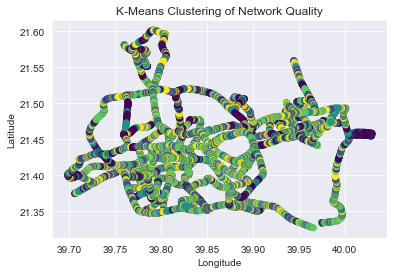

In [4]:
# Select features for clustering
features = df[['Latitude', 'Longitude', 'GSM Rx Qual-GSM Serving Cell Rx Qual Sub', 'GSM Power-GSM Serving Cell Rx Level Sub']].dropna()

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5)  
kmeans.fit(features)
features['Cluster'] = kmeans.labels_

# Plot the clusters
plt.scatter(features['Longitude'], features['Latitude'], c=features['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Network Quality')
plt.show()


Classification

In [8]:
# Drop rows with any NaN values in the columns of interest
filtered_df = df.dropna(subset=[
    'GSM Rx Qual-GSM Serving Cell Rx Qual Sub',
    'GSM Power-GSM Serving Cell Rx Level Sub',
    'Audio MOS Downlink-Audio DL MOS',
    'Audio  Quality.POLQA Downlink MOS-POLQA NB'
])

# Define quality categories (this is just an example, adjust as needed)
filtered_df['Quality_Category'] = filtered_df['GSM Rx Qual-GSM Serving Cell Rx Qual Sub'].apply(
    lambda x: 'Good' if x < 3 else 'Moderate' if x < 6 else 'Poor'
)

# Select features and target
features = filtered_df[['GSM Rx Qual-GSM Serving Cell Rx Qual Sub',
                        'GSM Power-GSM Serving Cell Rx Level Sub',
                        'Audio MOS Downlink-Audio DL MOS',
                        'Audio  Quality.POLQA Downlink MOS-POLQA NB']]

target = filtered_df['Quality_Category']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


/var/folders/z5/68b3704s6qj2p9gk1hfwfr7r0000gn/T/ipykernel_29449/2001733798.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Quality_Category'] = filtered_df['GSM Rx Qual-GSM Serving Cell Rx Qual Sub'].apply(


              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       408
    Moderate       1.00      1.00      1.00        32
        Poor       1.00      1.00      1.00         3

    accuracy                           1.00       443
   macro avg       1.00      1.00      1.00       443
weighted avg       1.00      1.00      1.00       443


Chech above overfitting!!!!!!!!


Regression

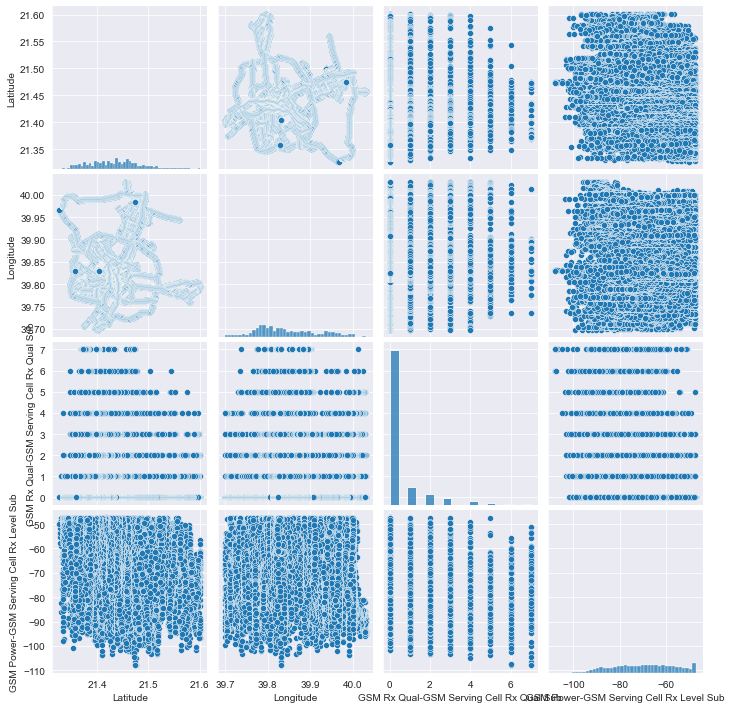

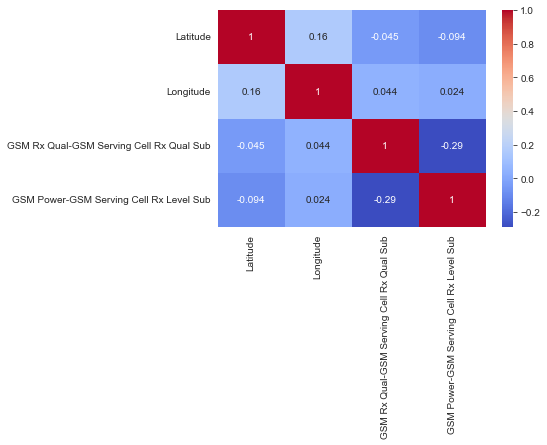

Linear Regression Mean Squared Error: 149.20604961146108
Ridge Regression Mean Squared Error: 149.19907786428243
Lasso Regression Mean Squared Error: 152.07372990888206
Random Forest Mean Squared Error: 56.29644726631808
Best Random Forest Mean Squared Error after tuning: 56.40033096935291


In [17]:
# Drop rows with any NaN values in the columns of interest
filtered_df = df.dropna(subset=[
    'Latitude',
    'Longitude',
    'GSM Rx Qual-GSM Serving Cell Rx Qual Sub',
    'GSM Power-GSM Serving Cell Rx Level Sub'
]).copy()

# Select features and target
features = filtered_df[['Latitude', 'Longitude', 'GSM Rx Qual-GSM Serving Cell Rx Qual Sub']]
target = filtered_df['GSM Power-GSM Serving Cell Rx Level Sub']

# Data Visualization
sns.pairplot(filtered_df[['Latitude', 'Longitude', 'GSM Rx Qual-GSM Serving Cell Rx Qual Sub', 'GSM Power-GSM Serving Cell Rx Level Sub']])
plt.show()

# Correlation Matrix
corr_matrix = filtered_df[['Latitude', 'Longitude', 'GSM Rx Qual-GSM Serving Cell Rx Qual Sub', 'GSM Power-GSM Serving Cell Rx Level Sub']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Try different models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} Mean Squared Error: {mse}')

# Hyperparameter tuning for Random Forest as an example
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Best Random Forest Mean Squared Error after tuning:', mse)